# Benchmark PySpark vs PyThoth

## Generating Dataset

In [1]:
import random

small_list = [random.randint(1, 100) for _ in range(50)]
medium_list = [random.randint(1, 100) for _ in range(5000)]
large_list = [random.randint(1, 100) for _ in range(500000)]
extra_large_list = [random.randint(1, 100) for _ in range(5000000)]

# PySpark Benchmark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
import time

In [4]:
#192.168.122.217    spark-master

MASTER_IP = "spark-master"

spark = (
    SparkSession.builder.appName("Thoth Benchmark")
    .master(f"spark://{MASTER_IP}:7077")
    # .config("spark.executor.memory", "1g")
    # .config("spark.driver.memory", "1g")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/13 12:34:25 WARN Utils: Your hostname, akm, resolves to a loopback address: 127.0.1.1; using 192.168.1.5 instead (on interface enp3s0)
25/10/13 12:34:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/13 12:34:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Average Calculations

In [5]:
# Create DataFrames, this step takes a lot of time
small_df = spark.createDataFrame(small_list, "int").toDF("value")
medium_df = spark.createDataFrame(medium_list, "int").toDF("value")
large_df = spark.createDataFrame(large_list, "int").toDF("value")
extra_large_list_df = spark.createDataFrame(extra_large_list, "int").toDF("value")

In [6]:
def spark_avg(df, label):
    start_time = time.time()
    df.agg(avg("value")).show()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"\nSpark Time taken to process {label} DataFrame: {elapsed} seconds")
    return elapsed




In [6]:
py_spark_avg_small_list_time = spark_avg(small_df, "small")
py_spark_avg_medium_list_time = spark_avg(medium_df, "medium")
py_spark_avg_large_list_time = spark_avg(large_df, "large")
py_spark_avg_extra_large_list_time = spark_avg(extra_large_list_df, "extra large")

+----------+
|avg(value)|
+----------+
|     46.28|
+----------+


Spark Time taken to process small DataFrame: 2.6443686485290527 seconds
+----------+
|avg(value)|
+----------+
|     51.33|
+----------+


Spark Time taken to process medium DataFrame: 0.21628379821777344 seconds
+----------+
|avg(value)|
+----------+
| 50.543384|
+----------+


Spark Time taken to process large DataFrame: 0.3885481357574463 seconds


25/10/13 12:20:10 WARN TaskSetManager: Stage 9 contains a task of very large size (6561 KiB). The maximum recommended task size is 1000 KiB.


+----------+
|avg(value)|
+----------+
| 50.483659|
+----------+


Spark Time taken to process extra large DataFrame: 1.1743254661560059 seconds


### Min Max Calculations

In [7]:
from pyspark.sql.functions import min as spark_min, max as spark_max
def spark_min_max(df, label):
    # Min timing
    start_time = time.time()
    min_value = df.agg(spark_min("value").alias("min")).collect()[0]['min']
    end_time = time.time()
    min_time = end_time - start_time
    print(f"{label} List - Min: {min_value}")
    print(f"Spark Time taken for {label} min: {min_time} seconds")

    # Max timing
    start_time = time.time()
    max_value = df.agg(spark_max("value").alias("max")).collect()[0]['max']
    end_time = time.time()
    max_time = end_time - start_time
    print(f"{label} List - Max: {max_value}")
    print(f"Spark Time taken for {label} max: {max_time} seconds")

    return min_value, min_time, max_value, max_time



In [8]:

small_min, py_spark_small_min_time, small_max, py_spark_small_max_time = spark_min_max(small_df, "Small")
medium_min, py_spark_medium_min_time, medium_max, py_spark_medium_max_time = spark_min_max(medium_df, "Medium")
large_min, py_spark_large_min_time, large_max, py_spark_large_max_time = spark_min_max(large_df, "Large")
extra_large_min, py_spark_extra_large_min_time, extra_large_max, py_spark_extra_large_max_time = spark_min_max(extra_large_list_df, "Extra Large")

Small List - Min: 10
Spark Time taken for Small min: 0.2244729995727539 seconds
Small List - Max: 99
Spark Time taken for Small max: 0.21910691261291504 seconds
Medium List - Min: 1
Spark Time taken for Medium min: 0.16849374771118164 seconds
Medium List - Max: 100
Spark Time taken for Medium max: 0.16565728187561035 seconds
Large List - Min: 1
Spark Time taken for Large min: 0.22012901306152344 seconds
Large List - Max: 100
Spark Time taken for Large max: 0.23435449600219727 seconds


25/10/13 12:20:13 WARN TaskSetManager: Stage 30 contains a task of very large size (6561 KiB). The maximum recommended task size is 1000 KiB.
25/10/13 12:20:13 WARN TaskSetManager: Stage 33 contains a task of very large size (6561 KiB). The maximum recommended task size is 1000 KiB.


Extra Large List - Min: 1
Spark Time taken for Extra Large min: 0.8743674755096436 seconds


Extra Large List - Max: 100
Spark Time taken for Extra Large max: 0.943953275680542 seconds


### Sorting Calculations

In [8]:
from pyspark.sql.functions import asc
def spark_sort_asc(df, label):
    start_time = time.time()
    sorted_df = df.orderBy(asc("value"))
    sorted_df.show()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Spark Time taken to sort {label} list ascending: {elapsed} seconds")
    return sorted_df, elapsed


In [ ]:

small_sorted_asc, py_spark_small_sort_asc_time = spark_sort_asc(small_df, "small")
medium_sorted_asc, py_spark_medium_sort_asc_time = spark_sort_asc(medium_df, "medium")
large_sorted_asc, py_spark_large_sort_asc_time = spark_sort_asc(large_df, "large")
extra_large_sorted_asc, py_spark_extra_large_sort_asc_time = spark_sort_asc(extra_large_list_df, "extra large")


+-----+
|value|
+-----+
|   10|
|   10|
|   13|
|   13|
|   13|
|   15|
|   21|
|   21|
|   24|
|   25|
|   25|
|   26|
|   27|
|   28|
|   28|
|   29|
|   32|
|   34|
|   35|
|   37|
+-----+
only showing top 20 rows
Spark Time taken to sort small list ascending: 0.3346848487854004 seconds
+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort medium list ascending: 0.12703967094421387 seconds
+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort large list ascending: 0.265439510345459 seconds


25/10/13 12:20:15 WARN TaskSetManager: Stage 39 contains a task of very large size (6561 KiB). The maximum recommended task size is 1000 KiB.


+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort extra large list ascending: 1.023355484008789 seconds


25/10/13 12:20:53 ERROR TransportClient: Failed to send RPC RPC 8106516302282259907 to /192.168.122.215:51448
io.netty.channel.StacklessClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source)
25/10/13 12:20:53 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 27 from block manager BlockManagerId(0, 192.168.122.215, 42069, None)
java.io.IOException: Failed to send RPC RPC 8106516302282259907 to /192.168.122.215:51448: io.netty.channel.StacklessClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:401)
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:378)
	at io.netty.util.concurrent.DefaultPromise.notifyListener0(DefaultPromise.java:590)
	at io.netty.util.concurrent.DefaultPromise.notifyListenersNow(DefaultPromise.java:557)
	at io.netty.util.concurrent.DefaultPromise.notify

# Thoth BenchMark

In [9]:
from py_thoth.operations.vector import list_average
from py_thoth.settings.connections import change_remote_address
remote_addresses = ["192.168.122.217:50051", "192.168.122.215:50051"]
# remote_addresses = ["localhost:50051", "localhost:50052"]
# remote_addresses = ["localhost:50051"]
change_remote_address(remote_addresses)


Remote address changed to: ['192.168.122.217:50051', '192.168.122.215:50051']


### Average Calculations

In [10]:
def thoth_avg_benchmark(lst, label):
    start_time = time.time()
    avg_value = list_average(lst)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Average {label} List: {avg_value}")
    print(f"\nThoth {label} List Time taken: {elapsed} seconds")
    return elapsed



In [13]:

thoth_small_list_time = thoth_avg_benchmark(small_list, "Small")
thoth_medium_list_time = thoth_avg_benchmark(medium_list, "Medium")
thoth_large_list_time = thoth_avg_benchmark(large_list, "Large")
thoth_extra_large_list_time = thoth_avg_benchmark(extra_large_list, "Extra Large")

Average Small List: 46.28

Thoth Small List Time taken: 0.02442169189453125 seconds
Average Medium List: 51.33

Thoth Medium List Time taken: 0.006456613540649414 seconds
Average Large List: 50.543384

Thoth Large List Time taken: 0.12210965156555176 seconds
Average Extra Large List: 50.483659

Thoth Extra Large List Time taken: 1.3483555316925049 seconds


### Min Max, Sorting Calculations

In [11]:
from py_thoth.operations.vector import sort_list, max_list, min_list
def thoth_min_benchmark(lst, label):
    start_time = time.time()
    min_value = min_list(lst)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"{label} List - Min (Thoth): {min_value}")
    print(f"Thoth Time taken for {label} min: {elapsed} seconds")
    return min_value, elapsed

In [15]:
thoth_small_min, thoth_small_min_time = thoth_min_benchmark(small_list, "Small")
thoth_medium_min, thoth_medium_min_time = thoth_min_benchmark(medium_list, "Medium")
thoth_large_min, thoth_large_min_time = thoth_min_benchmark(large_list, "Large")
thoth_extra_large_min, thoth_extra_large_min_time = thoth_min_benchmark(extra_large_list, "Extra Large")

Small List - Min (Thoth): 10.0
Thoth Time taken for Small min: 0.0048673152923583984 seconds
Medium List - Min (Thoth): 1.0
Thoth Time taken for Medium min: 0.007274627685546875 seconds
Large List - Min (Thoth): 1.0
Thoth Time taken for Large min: 0.09635186195373535 seconds
Extra Large List - Min (Thoth): 1.0
Thoth Time taken for Extra Large min: 1.265929937362671 seconds


In [12]:
def thoth_max_benchmark(lst, label):
    start_time = time.time()
    max_value = max_list(lst)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"{label} List - Max (Thoth): {max_value}")
    print(f"Thoth Time taken for {label} max: {elapsed} seconds")
    return max_value, elapsed


In [17]:

thoth_small_max, thoth_small_max_time = thoth_max_benchmark(small_list, "Small")
thoth_medium_max, thoth_medium_max_time = thoth_max_benchmark(medium_list, "Medium")
thoth_large_max, thoth_large_max_time = thoth_max_benchmark(large_list, "Large")
thoth_extra_large_max, thoth_extra_large_max_time = thoth_max_benchmark(extra_large_list, "Extra Large")

Small List - Max (Thoth): 99.0
Thoth Time taken for Small max: 0.007831573486328125 seconds
Medium List - Max (Thoth): 100.0
Thoth Time taken for Medium max: 0.005984783172607422 seconds
Large List - Max (Thoth): 100.0
Thoth Time taken for Large max: 0.12839698791503906 seconds
Extra Large List - Max (Thoth): 100.0
Thoth Time taken for Extra Large max: 1.6402952671051025 seconds


In [13]:
def thoth_sort_asc_benchmark(lst, label):
    start_time = time.time()
    sorted_lst = sort_list(lst, ascending=True)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"{label} List - Sorted Ascending (Thoth): {sorted_lst[:10]} ...")
    print(f"Thoth Time taken to sort {label} list ascending: {elapsed} seconds")
    return sorted_lst, elapsed



In [19]:

thoth_small_sorted_asc, thoth_small_sort_asc_time = thoth_sort_asc_benchmark(small_list, "Small")
thoth_medium_sorted_asc, thoth_medium_sort_asc_time = thoth_sort_asc_benchmark(medium_list, "Medium")
thoth_large_sorted_asc, thoth_large_sort_asc_time = thoth_sort_asc_benchmark(large_list, "Large")
thoth_extra_large_sorted_asc, thoth_extra_large_sort_asc_time = thoth_sort_asc_benchmark(extra_large_list, "Extra Large")

Small List - Sorted Ascending (Thoth): [10.0, 10.0, 13.0, 13.0, 13.0, 15.0, 21.0, 25.0, 32.0, 34.0] ...
Thoth Time taken to sort Small list ascending: 0.004526376724243164 seconds
Medium List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Medium list ascending: 0.007857561111450195 seconds
Large List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Large list ascending: 0.1338198184967041 seconds
Extra Large List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Extra Large list ascending: 2.0076351165771484 seconds


### Plotting Results

In [1]:
import pandas as pd
def create_comparison_df():
    comparison_data = {
        "Dataset": [
            f"Small ({len(small_list):,})",
            f"Medium ({len(medium_list):,})",
            f"Large ({len(large_list):,})",
            f"Extra Large ({len(extra_large_list):,})"
        ],
        "Thoth Avg Time (s)": [
            thoth_small_list_time,
            thoth_medium_list_time,
            thoth_large_list_time,
            thoth_extra_large_list_time
        ],
        "PySpark Avg Time (s)": [
            py_spark_avg_small_list_time,
            py_spark_avg_medium_list_time,
            py_spark_avg_large_list_time,
            py_spark_avg_extra_large_list_time
        ],
        "Thoth Min Time (s)": [
            thoth_small_min_time,
            thoth_medium_min_time,
            thoth_large_min_time,
            thoth_extra_large_min_time
        ],
        "PySpark Min Time (s)": [
            py_spark_small_min_time,
            py_spark_medium_min_time,
            py_spark_large_min_time,
            py_spark_extra_large_min_time
        ],
        "Thoth Max Time (s)": [
            thoth_small_max_time,
            thoth_medium_max_time,
            thoth_large_max_time,
            thoth_extra_large_max_time
        ],
        "PySpark Max Time (s)": [
            py_spark_small_max_time,
            py_spark_medium_max_time,
            py_spark_large_max_time,
            py_spark_extra_large_max_time
        ],
        "Thoth Sort Asc Time (s)": [
            thoth_small_sort_asc_time,
            thoth_medium_sort_asc_time,
            thoth_large_sort_asc_time,
            thoth_extra_large_sort_asc_time
        ],
        "PySpark Sort Asc Time (s)": [
            py_spark_small_sort_asc_time,
            py_spark_medium_sort_asc_time,
            py_spark_large_sort_asc_time,
            py_spark_extra_large_sort_asc_time
        ]
    }
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.head())
    return df_comparison



In [21]:
df_comparison = create_comparison_df()

                   Dataset  Thoth Avg Time (s)  PySpark Avg Time (s)  \
0               Small (50)            0.024422              2.644369   
1           Medium (5,000)            0.006457              0.216284   
2          Large (500,000)            0.122110              0.388548   
3  Extra Large (5,000,000)            1.348356              1.174325   

   Thoth Min Time (s)  PySpark Min Time (s)  Thoth Max Time (s)  \
0            0.004867              0.224473            0.007832   
1            0.007275              0.168494            0.005985   
2            0.096352              0.220129            0.128397   
3            1.265930              0.874367            1.640295   

   PySpark Max Time (s)  Thoth Sort Asc Time (s)  PySpark Sort Asc Time (s)  
0              0.219107                 0.004526                   0.334685  
1              0.165657                 0.007858                   0.127040  
2              0.234354                 0.133820                   0.

In [ ]:
import os

OUTPUT_DIR = os.path.join("assets","benchmarks")
df_comparison.to_csv(os.path.join(OUTPUT_DIR, "thoth_vs_pyspark_benchmark_two_machines.csv"), index=False) 

In [2]:
import numpy as np

import matplotlib.pyplot as plt
def plot_benchmark_comparison(df_comparison, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    datasets = df_comparison["Dataset"]
    x = np.arange(len(datasets))  # the label locations
    width = 0.35  # the width of the bars
    # 1. Average Time Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, df_comparison["Thoth Avg Time (s)"], width, label='Thoth', color='skyblue')
    plt.bar(x + width/2, df_comparison["PySpark Avg Time (s)"], width, label='PySpark', color='salmon')
    plt.xticks(x, datasets, rotation=30)
    plt.ylabel('Time (seconds)')
    plt.title('Average Calculation Time Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "avg_time_comparison.png"))
    plt.show()

    # 2. Min Time Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, df_comparison["Thoth Min Time (s)"], width, label='Thoth', color='orange')
    plt.bar(x + width/2, df_comparison["PySpark Min Time (s)"], width, label='PySpark', color='lightgreen')
    plt.xticks(x, datasets, rotation=30)
    plt.ylabel('Time (seconds)')
    plt.title('Min Calculation Time Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "min_time_comparison.png"))
    plt.show()

    # 3. Max Time Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, df_comparison["Thoth Max Time (s)"], width, label='Thoth', color='orange')
    plt.bar(x + width/2, df_comparison["PySpark Max Time (s)"], width, label='PySpark', color='lightgreen')
    plt.xticks(x, datasets, rotation=30)
    plt.ylabel('Time (seconds)')
    plt.title('Max Calculation Time Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "max_time_comparison.png"))
    plt.show()

    # 4. Sort Ascending Time Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, df_comparison["Thoth Sort Asc Time (s)"], width, label='Thoth', color='purple')
    plt.bar(x + width/2, df_comparison["PySpark Sort Asc Time (s)"], width, label='PySpark', color='gray')
    plt.xticks(x, datasets, rotation=30)
    plt.ylabel('Time (seconds)')
    plt.title('Sort Ascending Time Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "sort_asc_time_comparison.png"))
    plt.show()


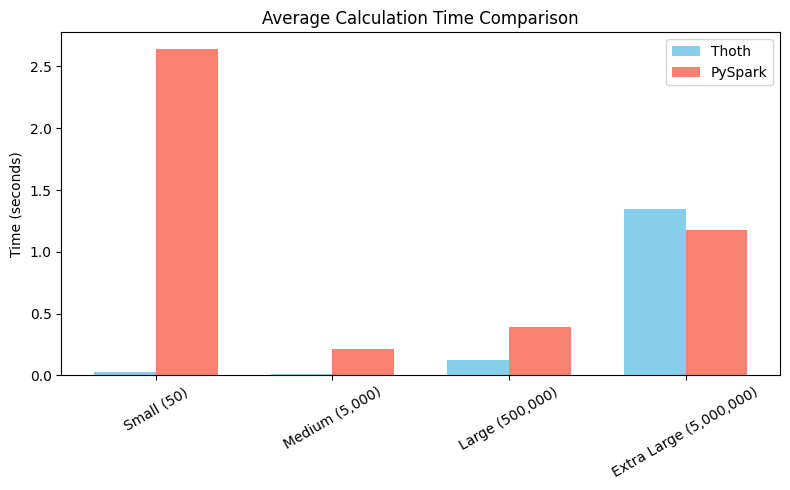

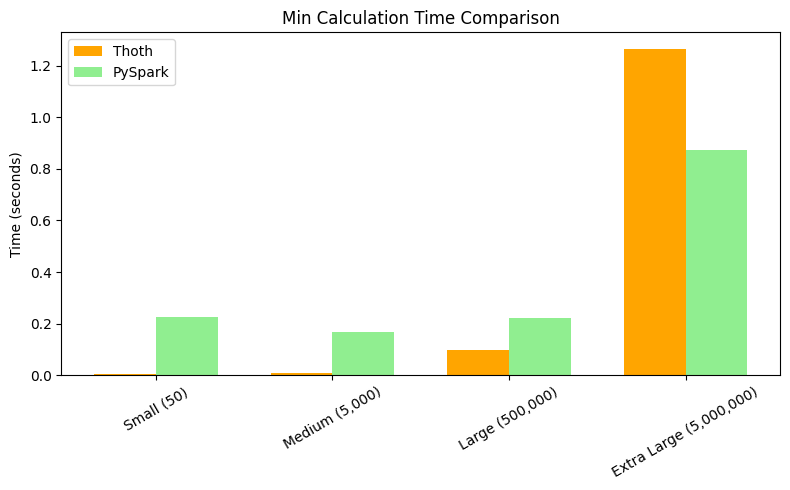

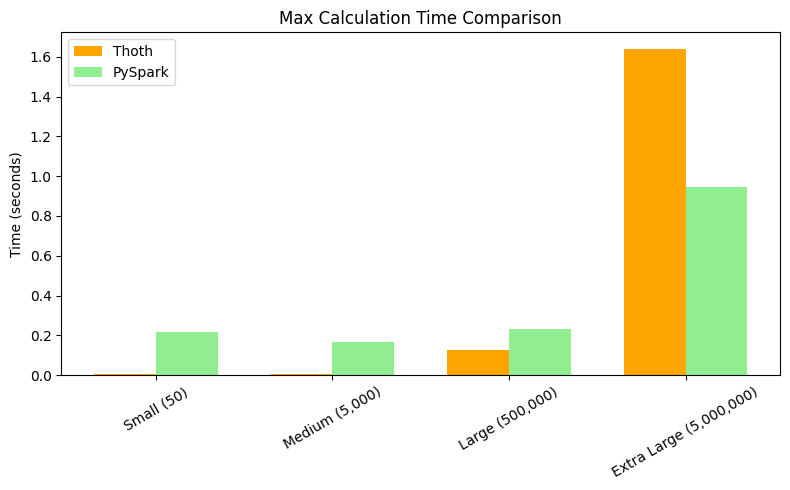

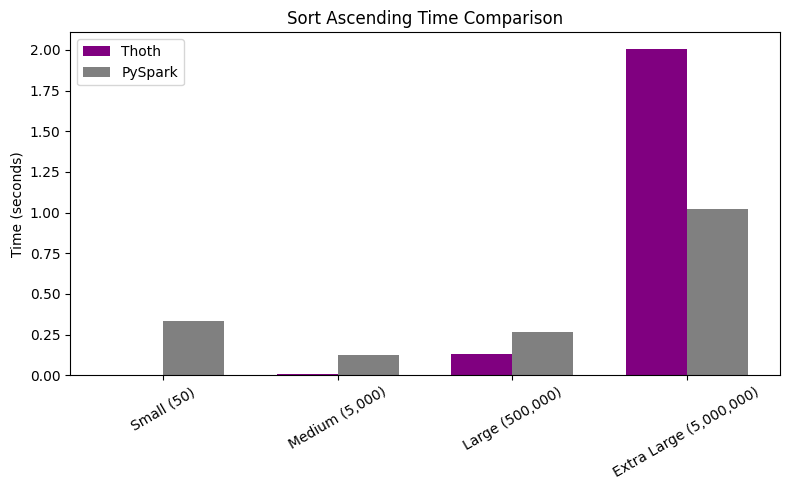

In [24]:

# Call the function
plot_benchmark_comparison(df_comparison, os.path.join(OUTPUT_DIR,"two_machines"))

## Three Machines

### Spark

In [ ]:
spark = (
    SparkSession.builder.appName("Thoth Benchmark")
    .master(f"spark://{MASTER_IP}:7077")
    .getOrCreate()
)

In [17]:
py_spark_avg_small_list_time = spark_avg(small_df, "small")
py_spark_avg_medium_list_time = spark_avg(medium_df, "medium")
py_spark_avg_large_list_time = spark_avg(large_df, "large")
py_spark_avg_extra_large_list_time = spark_avg(extra_large_list_df, "extra large")

+----------+
|avg(value)|
+----------+
|      54.1|
+----------+


Spark Time taken to process small DataFrame: 2.9557902812957764 seconds
+----------+
|avg(value)|
+----------+
|    50.364|
+----------+


Spark Time taken to process medium DataFrame: 0.3872530460357666 seconds
+----------+
|avg(value)|
+----------+
| 50.563216|
+----------+


Spark Time taken to process large DataFrame: 0.339127779006958 seconds


25/10/13 12:36:20 WARN TaskSetManager: Stage 9 contains a task of very large size (3283 KiB). The maximum recommended task size is 1000 KiB.


+----------+
|avg(value)|
+----------+
|50.5220306|
+----------+


Spark Time taken to process extra large DataFrame: 0.9706578254699707 seconds


In [18]:
small_min, py_spark_small_min_time, small_max, py_spark_small_max_time = spark_min_max(small_df, "Small")
medium_min, py_spark_medium_min_time, medium_max, py_spark_medium_max_time = spark_min_max(medium_df, "Medium")
large_min, py_spark_large_min_time, large_max, py_spark_large_max_time = spark_min_max(large_df, "Large")
extra_large_min, py_spark_extra_large_min_time, extra_large_max, py_spark_extra_large_max_time = spark_min_max(extra_large_list_df, "Extra Large")

Small List - Min: 1
Spark Time taken for Small min: 0.274782657623291 seconds
Small List - Max: 100
Spark Time taken for Small max: 0.22253918647766113 seconds
Medium List - Min: 1
Spark Time taken for Medium min: 0.1875777244567871 seconds
Medium List - Max: 100
Spark Time taken for Medium max: 0.19579744338989258 seconds
Large List - Min: 1
Spark Time taken for Large min: 0.2163832187652588 seconds
Large List - Max: 100
Spark Time taken for Large max: 0.2896761894226074 seconds


25/10/13 12:36:22 WARN TaskSetManager: Stage 30 contains a task of very large size (3283 KiB). The maximum recommended task size is 1000 KiB.


Extra Large List - Min: 1
Spark Time taken for Extra Large min: 0.5993542671203613 seconds


25/10/13 12:36:23 WARN TaskSetManager: Stage 33 contains a task of very large size (3283 KiB). The maximum recommended task size is 1000 KiB.


Extra Large List - Max: 100
Spark Time taken for Extra Large max: 0.7459995746612549 seconds


In [19]:
small_sorted_asc, py_spark_small_sort_asc_time = spark_sort_asc(small_df, "small")
medium_sorted_asc, py_spark_medium_sort_asc_time = spark_sort_asc(medium_df, "medium")
large_sorted_asc, py_spark_large_sort_asc_time = spark_sort_asc(large_df, "large")
extra_large_sorted_asc, py_spark_extra_large_sort_asc_time = spark_sort_asc(extra_large_list_df, "extra large")


+-----+
|value|
+-----+
|    1|
|    2|
|    3|
|    3|
|   10|
|   13|
|   13|
|   15|
|   21|
|   21|
|   23|
|   25|
|   31|
|   34|
|   37|
|   38|
|   38|
|   38|
|   39|
|   41|
+-----+
only showing top 20 rows
Spark Time taken to sort small list ascending: 0.26639270782470703 seconds
+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort medium list ascending: 0.16219162940979004 seconds
+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort large list ascending: 0.23508763313293457 seconds


25/10/13 12:36:24 WARN TaskSetManager: Stage 39 contains a task of very large size (3283 KiB). The maximum recommended task size is 1000 KiB.


+-----+
|value|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows
Spark Time taken to sort extra large list ascending: 0.7687108516693115 seconds


25/10/13 12:37:02 ERROR TaskSchedulerImpl: Lost executor 0 on 192.168.122.33: Worker shutting down
25/10/13 12:37:02 WARN StandaloneAppClient$ClientEndpoint: Connection to 192.168.122.217:7077 failed; waiting for master to reconnect...
25/10/13 12:37:02 WARN StandaloneSchedulerBackend: Disconnected from Spark cluster! Waiting for reconnection...
25/10/13 12:37:07 ERROR TaskSchedulerImpl: Lost executor 1 on 192.168.122.215: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.


### Thoth

In [27]:
remote_addresses = ["192.168.122.217:50051", "192.168.122.215:50051", "192.168.122.33:50051"]

change_remote_address(remote_addresses)


Remote address changed to: ['192.168.122.217:50051', '192.168.122.215:50051', '192.168.122.33:50051']


In [28]:
thoth_small_list_time = thoth_avg_benchmark(small_list, "Small")
thoth_medium_list_time = thoth_avg_benchmark(medium_list, "Medium")
thoth_large_list_time = thoth_avg_benchmark(large_list, "Large")
thoth_extra_large_list_time = thoth_avg_benchmark(extra_large_list, "Extra Large")

Average Small List: 54.1

Thoth Small List Time taken: 0.024280309677124023 seconds
Average Medium List: 50.364

Thoth Medium List Time taken: 0.011145591735839844 seconds
Average Large List: 50.563216

Thoth Large List Time taken: 0.08014440536499023 seconds
Average Extra Large List: 50.5220306

Thoth Extra Large List Time taken: 1.094292163848877 seconds


In [29]:
thoth_small_min, thoth_small_min_time = thoth_min_benchmark(small_list, "Small")
thoth_medium_min, thoth_medium_min_time = thoth_min_benchmark(medium_list, "Medium")
thoth_large_min, thoth_large_min_time = thoth_min_benchmark(large_list, "Large")
thoth_extra_large_min, thoth_extra_large_min_time = thoth_min_benchmark(extra_large_list, "Extra Large")


Small List - Min (Thoth): 1.0
Thoth Time taken for Small min: 0.006825685501098633 seconds
Medium List - Min (Thoth): 1.0
Thoth Time taken for Medium min: 0.02917313575744629 seconds
Large List - Min (Thoth): 1.0
Thoth Time taken for Large min: 0.06647062301635742 seconds
Extra Large List - Min (Thoth): 1.0
Thoth Time taken for Extra Large min: 1.0313057899475098 seconds


In [30]:
thoth_small_max, thoth_small_max_time = thoth_max_benchmark(small_list, "Small")
thoth_medium_max, thoth_medium_max_time = thoth_max_benchmark(medium_list, "Medium")
thoth_large_max, thoth_large_max_time = thoth_max_benchmark(large_list, "Large")
thoth_extra_large_max, thoth_extra_large_max_time = thoth_max_benchmark(extra_large_list, "Extra Large")


Small List - Max (Thoth): 100.0
Thoth Time taken for Small max: 0.05917501449584961 seconds
Medium List - Max (Thoth): 100.0
Thoth Time taken for Medium max: 0.003727436065673828 seconds
Large List - Max (Thoth): 100.0
Thoth Time taken for Large max: 0.05974841117858887 seconds
Extra Large List - Max (Thoth): 100.0
Thoth Time taken for Extra Large max: 0.7306630611419678 seconds


In [31]:
thoth_small_sorted_asc, thoth_small_sort_asc_time = thoth_sort_asc_benchmark(small_list, "Small")
thoth_medium_sorted_asc, thoth_medium_sort_asc_time = thoth_sort_asc_benchmark(medium_list, "Medium")
thoth_large_sorted_asc, thoth_large_sort_asc_time = thoth_sort_asc_benchmark(large_list, "Large")
thoth_extra_large_sorted_asc, thoth_extra_large_sort_asc_time = thoth_sort_asc_benchmark(extra_large_list, "Extra Large")

Small List - Sorted Ascending (Thoth): [1.0, 2.0, 3.0, 3.0, 10.0, 13.0, 13.0, 15.0, 21.0, 21.0] ...
Thoth Time taken to sort Small list ascending: 0.00324249267578125 seconds
Medium List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Medium list ascending: 0.007237434387207031 seconds
Large List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Large list ascending: 0.20250177383422852 seconds
Extra Large List - Sorted Ascending (Thoth): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] ...
Thoth Time taken to sort Extra Large list ascending: 2.67730975151062 seconds


## Plotting Results

In [32]:
df_comparison = create_comparison_df()
df_comparison.to_csv(os.path.join(OUTPUT_DIR, "thoth_vs_pyspark_benchmark_three_machines.csv"), index=False) 


                   Dataset  Thoth Avg Time (s)  PySpark Avg Time (s)  \
0               Small (50)            0.024280              2.955790   
1           Medium (5,000)            0.011146              0.387253   
2          Large (500,000)            0.080144              0.339128   
3  Extra Large (5,000,000)            1.094292              0.970658   

   Thoth Min Time (s)  PySpark Min Time (s)  Thoth Max Time (s)  \
0            0.006826              0.274783            0.059175   
1            0.029173              0.187578            0.003727   
2            0.066471              0.216383            0.059748   
3            1.031306              0.599354            0.730663   

   PySpark Max Time (s)  Thoth Sort Asc Time (s)  PySpark Sort Asc Time (s)  
0              0.222539                 0.003242                   0.266393  
1              0.195797                 0.007237                   0.162192  
2              0.289676                 0.202502                   0.

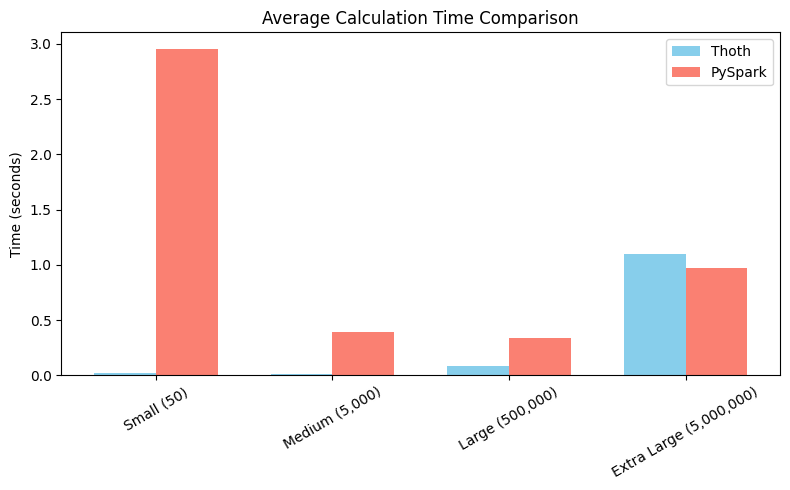

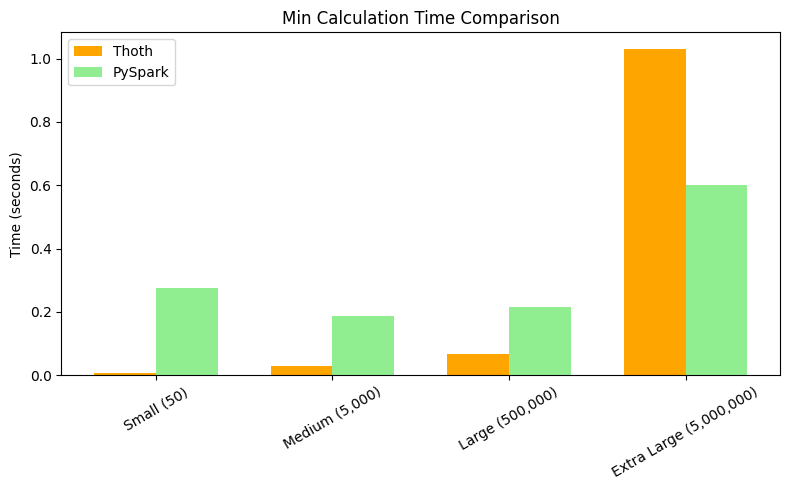

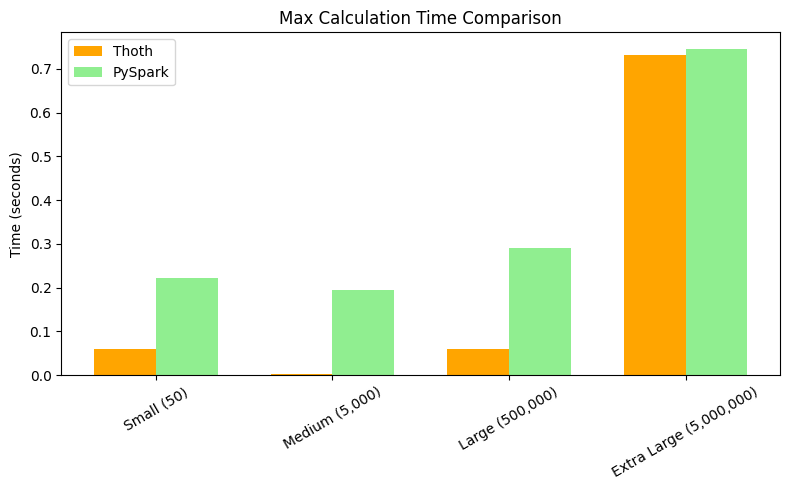

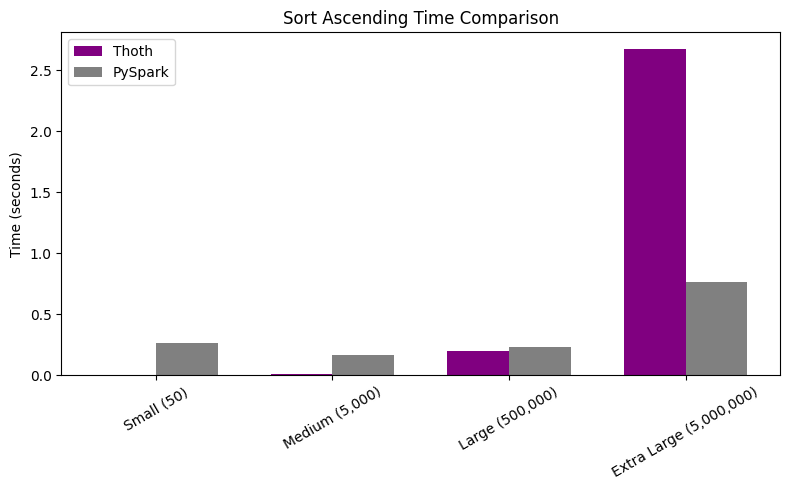

In [33]:
plot_benchmark_comparison(df_comparison, os.path.join(OUTPUT_DIR,"three_machines"))

# General Plots

In [6]:

two_machines_df = pd.read_csv(os.path.join(OUTPUT_DIR, "thoth_vs_pyspark_benchmark_two_machines.csv"))
three_machines_df = pd.read_csv(os.path.join(OUTPUT_DIR, "thoth_vs_pyspark_benchmark_three_machines.csv"))

In [9]:
two_machines_df.head()

,Dataset,Thoth Avg Time (s),PySpark Avg Time (s),Thoth Min Time (s),PySpark Min Time (s),Thoth Max Time (s),PySpark Max Time (s),Thoth Sort Asc Time (s),PySpark Sort Asc Time (s)
0,Small (50),0.024422,2.644369,0.004867,0.224473,0.007832,0.219107,0.004526,0.334685
1,"Medium (5,000)",0.006457,0.216284,0.007275,0.168494,0.005985,0.165657,0.007858,0.127040
2,"Large (500,000)",0.122110,0.388548,0.096352,0.220129,0.128397,0.234354,0.133820,0.265440
3,"Extra Large (5,000,000)",1.348356,1.174325,1.265930,0.874367,1.640295,0.943953,2.007635,1.023355


In [10]:
three_machines_df.head()

,Dataset,Thoth Avg Time (s),PySpark Avg Time (s),Thoth Min Time (s),PySpark Min Time (s),Thoth Max Time (s),PySpark Max Time (s),Thoth Sort Asc Time (s),PySpark Sort Asc Time (s)
0,Small (50),0.024280,2.955790,0.006826,0.274783,0.059175,0.222539,0.003242,0.266393
1,"Medium (5,000)",0.011146,0.387253,0.029173,0.187578,0.003727,0.195797,0.007237,0.162192
2,"Large (500,000)",0.080144,0.339128,0.066471,0.216383,0.059748,0.289676,0.202502,0.235088
3,"Extra Large (5,000,000)",1.094292,0.970658,1.031306,0.599354,0.730663,0.746000,2.677310,0.768711


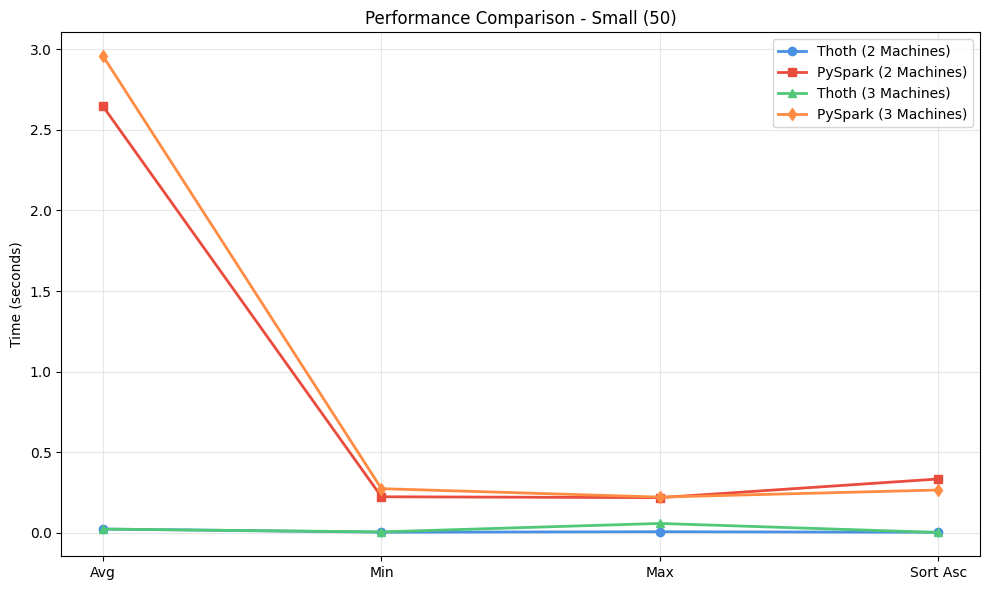

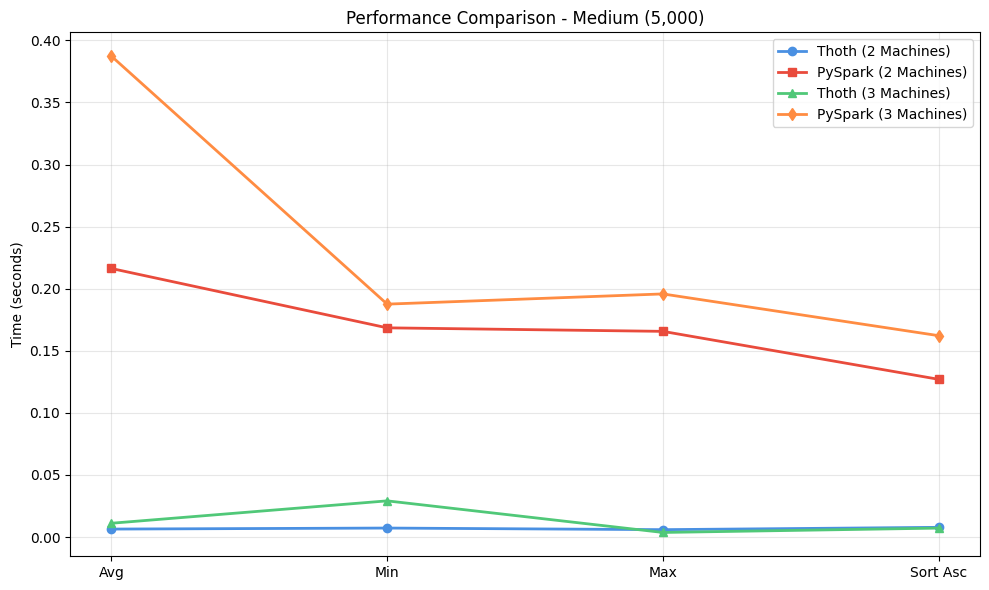

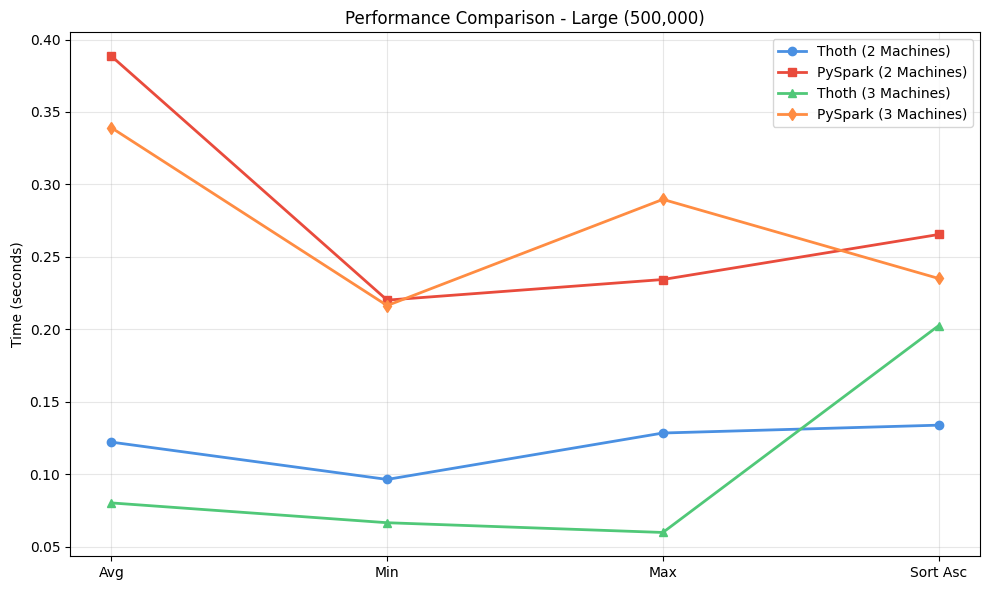

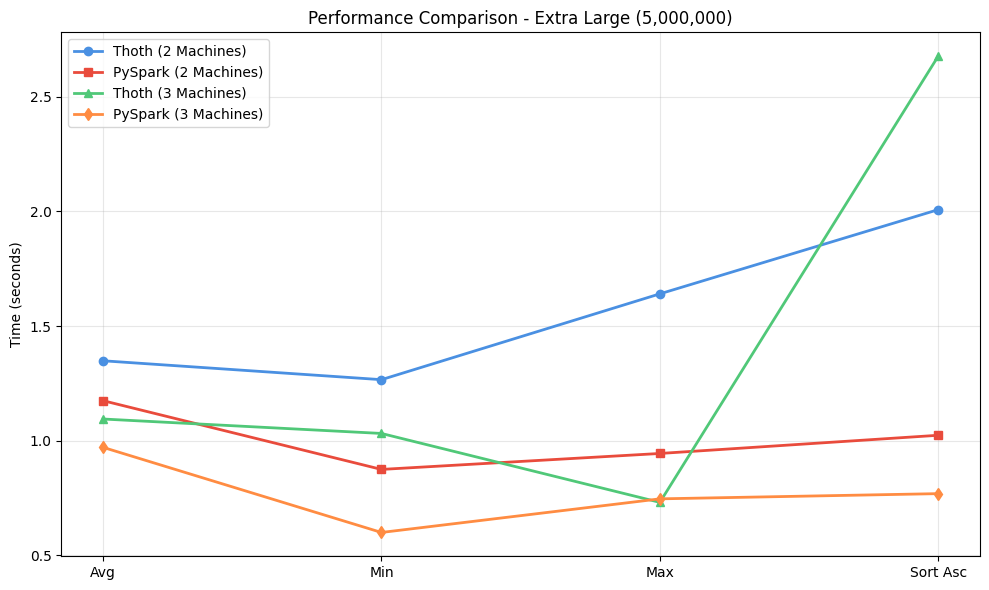

In [17]:
def plot_combined_comparison(two_machines_df, three_machines_df, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    datasets = two_machines_df["Dataset"]
    operations = ["Avg", "Min", "Max", "Sort Asc"]
    
    for i, dataset in enumerate(datasets):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Extract data for this dataset
        thoth_2m = [
            two_machines_df.iloc[i]["Thoth Avg Time (s)"],
            two_machines_df.iloc[i]["Thoth Min Time (s)"],
            two_machines_df.iloc[i]["Thoth Max Time (s)"],
            two_machines_df.iloc[i]["Thoth Sort Asc Time (s)"]
        ]
        
        pyspark_2m = [
            two_machines_df.iloc[i]["PySpark Avg Time (s)"],
            two_machines_df.iloc[i]["PySpark Min Time (s)"],
            two_machines_df.iloc[i]["PySpark Max Time (s)"],
            two_machines_df.iloc[i]["PySpark Sort Asc Time (s)"]
        ]
        
        thoth_3m = [
            three_machines_df.iloc[i]["Thoth Avg Time (s)"],
            three_machines_df.iloc[i]["Thoth Min Time (s)"],
            three_machines_df.iloc[i]["Thoth Max Time (s)"],
            three_machines_df.iloc[i]["Thoth Sort Asc Time (s)"]
        ]
        
        pyspark_3m = [
            three_machines_df.iloc[i]["PySpark Avg Time (s)"],
            three_machines_df.iloc[i]["PySpark Min Time (s)"],
            three_machines_df.iloc[i]["PySpark Max Time (s)"],
            three_machines_df.iloc[i]["PySpark Sort Asc Time (s)"]
        ]
        
        x = np.arange(len(operations))
        
        ax.plot(x, thoth_2m, marker='o', linewidth=2, label='Thoth (2 Machines)', color='#4A90E2')
        ax.plot(x, pyspark_2m, marker='s', linewidth=2, label='PySpark (2 Machines)', color='#E94B3C')
        ax.plot(x, thoth_3m, marker='^', linewidth=2, label='Thoth (3 Machines)', color='#50C878')
        ax.plot(x, pyspark_3m, marker='d', linewidth=2, label='PySpark (3 Machines)', color='#FF8C42')
        
        ax.set_ylabel('Time (seconds)')
        ax.set_title(f'Performance Comparison - {dataset}')
        ax.set_xticks(x)
        ax.set_xticklabels(operations)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        dataset_name = dataset.split()[0].lower()
        plt.savefig(os.path.join(output_dir, f"combined_comparison_{dataset_name}.png"))
        plt.show()

plot_combined_comparison(two_machines_df, three_machines_df, os.path.join(OUTPUT_DIR, "combined"))